<a href="https://colab.research.google.com/github/LEEINSEO-0118/Seed-size-calculator/blob/main/CalculateSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


# Calculate Functions

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import seaborn as sns
from tqdm import tqdm
import re

## Standard Template
사이즈 비교의 대상이 되는 템플릿


In [3]:
# 실제로 사용한 30mm x 30mm 사이즈의 종이 템플릿을 30배 스케일로 늘려 템플릿 생성
SCALE = 30
PAPER_W = 30 * SCALE
PAPER_H = 30 * SCALE

paper_coords = np.float32([[0,0],                # Top left
                           [PAPER_W,0],          # Top right
                           [0,PAPER_H],          # Bottom left
                           [PAPER_W,PAPER_H]])   # Bottom right

## Load Image and Show Image

In [4]:
def load_image(path, scale = 0.7):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (0,0), None, scale, scale)
    return img_resized

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.xticks([])
    plt.yticks([]) # 얘네 넣으면 축에 index가 사라지네?
    plt.imshow(img)
    plt.show()

## Image Preprocess
이미지 -> 그레이 스케일 -> Blur 처리 -> edge 추출 -> edge굵게 및 선명하게

In [364]:
def preprocess_image(img, thresh_1=57, thresh_2=232):
    img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # 그레이 스케일 변환
    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 1)       # 필터처리
    img_canny = cv2.Canny(img_blur, thresh_1, thresh_2)    # edge detector

    kernel = np.ones((4,4))    #4
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)    # edge 라인을 굵게
    img_closed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE,
                                  kernel, iterations=6)          # edge 내부 small holes 제거, edge를 명확하게

    img_preprocessed = img_closed.copy()

    img_each_step = {'img_dilated': img_dilated,
                     'img_canny'  : img_canny,
                     'img_blur'   : img_blur,
                     'img_gray'   : img_gray}

    return img_preprocessed, img_each_step

## Find Contours
Contour를 통해 모서리 추출

In [358]:
def find_contours(img_preprocessed, img_original, epsilon_param=0.04):
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_TREE, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour
    if hierarchy is None or len(contours) == 0:
        print('컨투어 없음')
        return img_original  # Contour가 없으면 원본 이미지 반환

    # HIERARCH : [[[Next, Previous, First_Child, Parent]]] # -1이면 없는 것
    # 컨투어 바깥의 노이즈 제거하기, 새로운 컨투어 리스트 생성
    max_index = np.argmax([cv2.contourArea(c) for c in contours])
    filtered_contours = contours[max_index:]
    
    polygons = []
    epsilon = epsilon_param * cv2.arcLength(curve=filtered_contours[0],
                                            closed=True)  # epsilon 값이 작으면 많은 코너를 탐지한다.
                                                            # 사이즈 기준 객체의 정확한 코너를 찾기 위해서 epsilon 값을 설정하는 것에 주의해야 함
    polygon = cv2.approxPolyDP(curve=filtered_contours[0],
                                epsilon=epsilon, closed=True)  # contour를 통해 코너(Curves) 추정
    polygon = polygon.reshape(4, 2)  # original output of cv2.approxPolyDP() is in the format (number of corners, 1, 2), where the middle axis is irrelevant in our case. Hence, we can safely discard it.
    polygons.append(polygon)

    img_temp = img_original.copy()
    for point in polygon:
        polygon_img = cv2.circle(img=img_temp, center=point,
                                    radius=8, color=(0,240,0),
                                    thickness=-1)
        

    return polygons, polygon_img, filtered_contours

모서리 좌표 순서 정렬

In [7]:
def reorder_coords(polygon):
    rect_coords = np.zeros((4, 2)) # 각 모서리 구해서 넣기

    # 왼쪽 상단이 0, 0
    # 좌표 합 가장 작은 것 -> 좌측 상단
    # 좌표 합 가장 큰 것 -> 우측 하단
    add = polygon.sum(axis=1) # 컬럼을 기준으로 합치기
    rect_coords[0] = polygon[np.argmin(add)]    # Top left # 최소값의 index 반환
    rect_coords[3] = polygon[np.argmax(add)]    # Bottom right

    # 차 y - x
    # 좌표 차 가장 작은 것 -> 우측 상한
    # 좌표 차 가장 큰 것 -> 좌측 하단
    subtract = np.diff(polygon, axis=1)
    rect_coords[1] = polygon[np.argmin(subtract)]    # Top right
    rect_coords[2] = polygon[np.argmax(subtract)]    # Bottom left

    return rect_coords

## Perspective Transform

호모그래피 추출 및 원근 변환

In [8]:
def warp_image(rect_coords, paper_coords, img_original, pad=25):

    # 실제 이미지에서 template으로 변환하는 homography 생성
    matrix, _ = cv2.findHomography(rect_coords, paper_coords)

    # trasform
    img_warped = cv2.warpPerspective(img_original, matrix,
                                        (PAPER_W, PAPER_H))

    # 이미지가 원하지 않는 영역을 가지기에 pad 만큼 그것을 제거
    # 음.. 꼭 해야하나..?
    # -> 이거 안하니까 계산기 corner가 안 찾아짐... 미친.. 왜?
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]
    img_warped = img_warped[pad:warped_h-pad, pad:warped_w-pad]

    return img_warped

## Find Ellipse contours

종실 형태를 기준으로 타원을 형성 -> 타원을 기준으로 Rotated된 직사각형 생성 -> 종실의 크기 측정

In [357]:
def find_ellipse_contours(contours, img_original):
    img_contour = img_original.copy()
    cv2.drawContours(img_contour, contours[2], -1, (0, 255, 0), 2)  # 초록색 윤곽선 
    polygons = []

    return img_contour, polygons

## Calculate size

In [10]:
def calculate_sizes(polygons):
    sizes = []
    lens = len(polygons)
    for i in range(lens):
        for j in range(i+1, lens):
            dist = cv2.norm(polygons[i], polygons[j], cv2.NORM_L2)
            sizes.append([dist, [i, j]]) # 길이와 두 점의 index 저장

    sorted_sizes = sorted(sizes, key=lambda x: x[0])

    result = [sorted_sizes[0], sorted_sizes[3]]
    return result

In [11]:
def convert_to_mm(sizes_pixel, img_warped):
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]

    scale_h = PAPER_H / warped_h    # 높이 비율
    scale_w = PAPER_W / warped_w    # 너비 비율


    size_pixel_h, size_pixel_w = sizes_pixel[0][0], sizes_pixel[1][0]
    size_mm_h = size_pixel_h * scale_h / SCALE
    size_mm_w = size_pixel_w * scale_w / SCALE

    sizes_mm = [[size_mm_h, sizes_pixel[0][1]], [size_mm_w, sizes_pixel[1][1]]]

    return sizes_mm

## Print size

In [12]:
def write_size(polygons, sizes, img_warped):

    img_result = img_warped.copy()
    for size, idx in (sizes):
        cv2.line(img_result, polygons[idx[0]], polygons[idx[1]], (0,0,255), 4)
        cv2.putText(img_result, f'{np.float32(size):.2f}mm',
                    (polygons[idx[0]][0]-50, polygons[idx[0]][1]+100),
                    cv2.FONT_HERSHEY_DUPLEX, 0.9, (0,0,255), 1)

    return img_result

## Total Function

In [356]:
def measure_size(path, img_original_scale=0.7,
                 PAPER_W=30, PAPER_H=30, SCALE=30,
                 paper_eps_param=0.04,canny_thresh_1=57, canny_thresh_2=232):

    PAPER_W = PAPER_W * SCALE
    PAPER_H = PAPER_H * SCALE

    # Loading and preprocessing original image.
    img_original = load_image(path=path, scale=img_original_scale)
    img_preprocessed, img_each_step = preprocess_image(img_original,
                                                       thresh_1=canny_thresh_1,
                                                       thresh_2=canny_thresh_2)

    # Finding paper contours and corners.
    polygons, polygon_images, img_contours = find_contours(img_preprocessed,
                                           img_original,
                                           epsilon_param=paper_eps_param)


    # Reordering paper corners.
    rect_coords = np.float32(reorder_coords(polygons[0]))

    # Finding seed rectangle
    img_contours_warped, polygons = find_ellipse_contours(img_contours, img_original)

    show_image(img_contours_warped)

    # Edge langth calculation.
    seed_size = calculate_sizes(polygons)
    sizes_mm = convert_to_mm(seed_size, img_preprocessed)
    img_result = write_size(polygons, sizes_mm, img_original)
    return img_result, sizes_mm

# Calculate Images

## Get Image lists

In [50]:
path = f'/Users/toad/Documents/ToyProject/RealTime_Seed_Calculator/Data/'
file_lists = os.listdir(path+'Images')
file_lists.sort()
file_lists.remove('.DS_Store')
print(len(file_lists))
print(file_lists[:10])

42
['Seed_0.jpeg', 'Seed_1.jpeg', 'Seed_10.jpeg', 'Seed_11.jpeg', 'Seed_12.jpeg', 'Seed_13.jpeg', 'Seed_14.jpeg', 'Seed_15.jpeg', 'Seed_16.jpeg', 'Seed_17.jpeg']


In [51]:
# 이미지 labeling

# for i, file_name in tqdm(enumerate(file_lists)):
#     shutil.copyfile(path+f'Test_Images/{file_name}', path+f'Images/Seed_{i}.jpeg')

## Calculate


  0%|          | 0/6 [00:00<?, ?it/s]

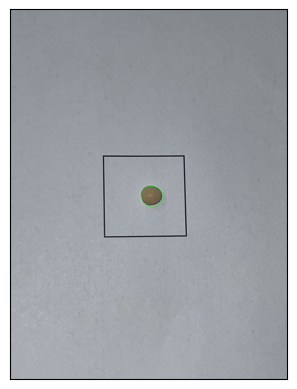

 17%|█▋        | 1/6 [00:00<00:02,  1.91it/s]

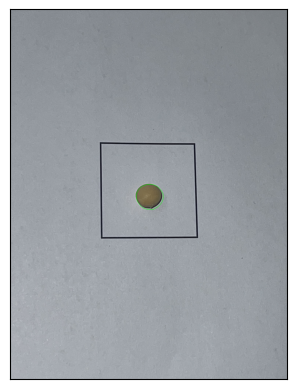

 33%|███▎      | 2/6 [00:01<00:02,  1.72it/s]

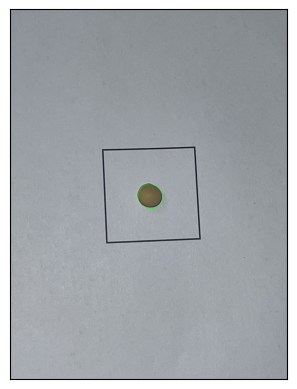

 50%|█████     | 3/6 [00:01<00:01,  1.80it/s]

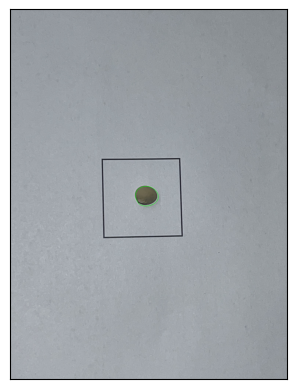

 67%|██████▋   | 4/6 [00:02<00:01,  1.84it/s]

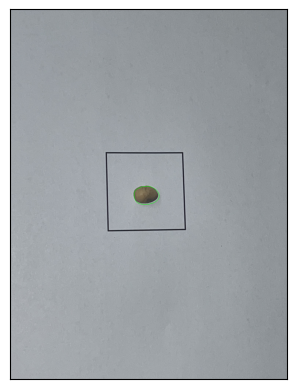

 83%|████████▎ | 5/6 [00:02<00:00,  1.84it/s]

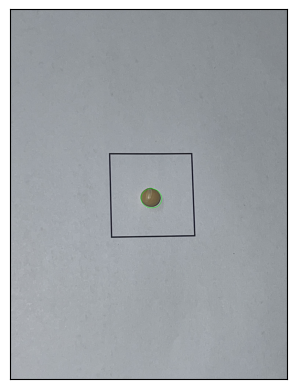

100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

0 6


In [365]:
correct_cnt = 0
fail_cnt = 0
for file_name in tqdm(file_lists[3:9]):
    try :
        cal_image, sizes = measure_size(path+f'Images/{file_name}', paper_eps_param = 0.08) # 작을 수록 많은 값을 코너를 탐지
        size_long = max(sizes[0][0], sizes[1][0])
        size_short = min(sizes[0][0], sizes[1][0])
        correct_cnt += 1
    except:
        fail_cnt += 1
print(correct_cnt, fail_cnt)

In [ ]:
# [[[Next, Previous, First_Child, Parent]]] # -1이면 없는 것